# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [1]:
import sys

import pandas as pd

from IPython.display import HTML

sys.path.append('../')
n_jobs = 20

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
train_parquet_path = constants['train_parquet_path']
test_parquet_path = constants['test_parquet_path']

attack_category = constants['attack_category']

## Read datasets

In [4]:
%%time

df = pd.read_parquet(parquet_path)
df_train = pd.read_parquet(train_parquet_path)
df_test = pd.read_parquet(test_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_train)

CPU times: user 38.8 s, sys: 11.6 s, total: 50.4 s
Wall time: 10.5 s


# Results from the original paper

## 7+1 Classes

              precision    recall  f1-score   support

      Benign     0.8155    0.9462    0.8760    243322
  BruteForce     0.9932    0.1468    0.2558      2983
        DDoS     0.9992    0.9997    0.9994   7526151
         DoS     0.9994    0.9972    0.9983   1792167
       Mirai     0.9989    0.9993    0.9991    583677
       Recon     0.7048    0.7078    0.7063     78630
    Spoofing     0.8834    0.6239    0.7313    107798
         Web     0.9718    0.0381    0.0733      5433

    accuracy                         0.9911  10340161
   macro avg     0.9208    0.6824    0.7050  10340161
weighted avg     0.9911    0.9911    0.9911  10340161



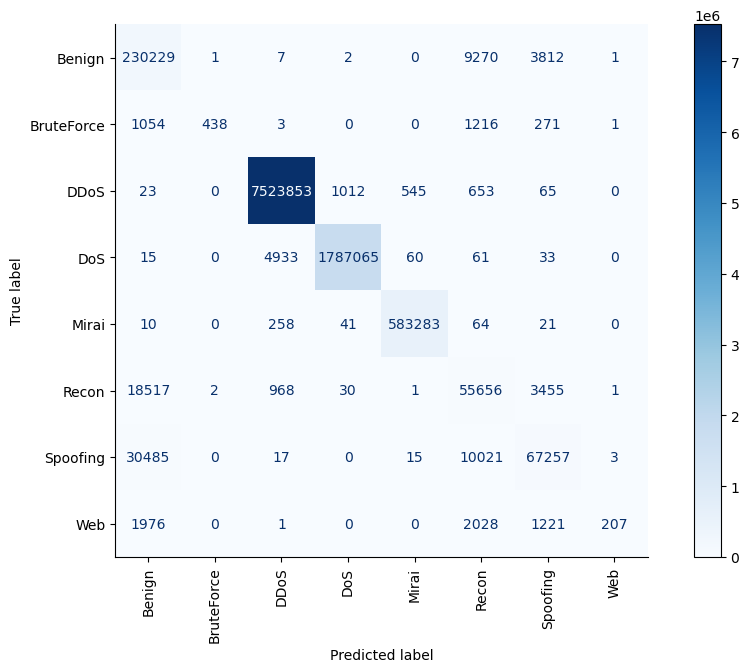

In [5]:
paper_confusion_matrix = pd.DataFrame.from_dict({
    'Benign': [230229,1,7,2,0,9270,3812,1],
    'BruteForce': [1054,438,3,0,0,1216,271,1],
    'DDoS': [23,0,7523853,1012,545,653,65,0],
    'DoS': [15,0,4933,1787065,60,61,33,0],
    'Mirai': [10,0,258,41,583283,64,21,0],
    'Recon': [18517,2,968,30,1,55656,3455,1],
    'Spoofing': [30485,0,17,0,15,10021,67257,3],
    'Web': [1976,0,1,0,0,2028,1221,207],
}, orient='index')

model_utils.show_metrics(
    paper_confusion_matrix.values,
    labels=paper_confusion_matrix.index
)

In [6]:
display(HTML(f"""
<p>
    Interesting to notice that in the paper, the authors mention that they have used a <strong>80/20 split</strong>,
    but based on the length of the dataset released and the absolute values in the Confusion Matrix, 
    we see a slightly different distribution, with the Test data having 
    <strong>{paper_confusion_matrix.sum().sum() / len(df):.2%}</strong> of the data.
</p>
"""))

# Baseline

## 33+1 Attacks

In [20]:
baseline_df_split = model_utils.get_train_test_split(
    df,
    target='label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [9]:
%%time

baseline_model = RandomForestClassifier(n_jobs=n_jobs, random_state=seed)

X_train, X_test, y_train, y_test = baseline_df_split

model_utils.train_model(
    baseline_model,
    X_train,
    y_train,
    save_name='baseline_random_forest'
)

Execution time (Model fit): 0:18:56.548947
CPU times: user 6h 55min 21s, sys: 4min 42s, total: 7h 3s
Wall time: 19min 49s


RandomForestClassifier(n_jobs=30, random_state=6958)

In [ ]:
baseline_model = model_utils.model_load('simplified_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = baseline_df_split
model_utils.evaluate_model(baseline_model, X_test, y_test)

## 7+1 Attacks

In [12]:
simplified_baseline_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [6]:
%%time

simplified_baseline_model = RandomForestClassifier(n_jobs=n_jobs, random_state=seed)

X_train, X_test, y_train, y_test = simplified_baseline_df_split

model_utils.train_model(
    simplified_baseline_model,
    X_train,
    y_train,
    save_name='simplified_baseline_random_forest'
)

Execution time (Model fit): 0:17:34.903705
CPU times: user 6h 54min 10s, sys: 4min 17s, total: 6h 58min 27s
Wall time: 17min 39s


RandomForestClassifier(n_jobs=30, random_state=6958)

Loading model 'simplified_baseline_random_forest' (3.35 GB)
# Nodes: 28121672
Execution time (Predict): 0:00:28.847492
              precision    recall  f1-score   support

      Benign     0.9256    0.9811    0.9526    219545
  BruteForce     0.9960    0.5655    0.7214      2656
        DDoS     0.9999    1.0000    0.9999   6797400
         DoS     0.9999    0.9999    0.9999   1617348
       Mirai     1.0000    1.0000    1.0000    526792
       Recon     0.9112    0.8468    0.8778     70864
    Spoofing     0.9208    0.8777    0.8987     97575
         Web     0.9797    0.4521    0.6187      5136

    accuracy                         0.9966   9337316
   macro avg     0.9666    0.8404    0.8836   9337316
weighted avg     0.9966    0.9966    0.9966   9337316

CPU times: user 6min 29s, sys: 36.9 s, total: 7min 6s
Wall time: 1min 37s


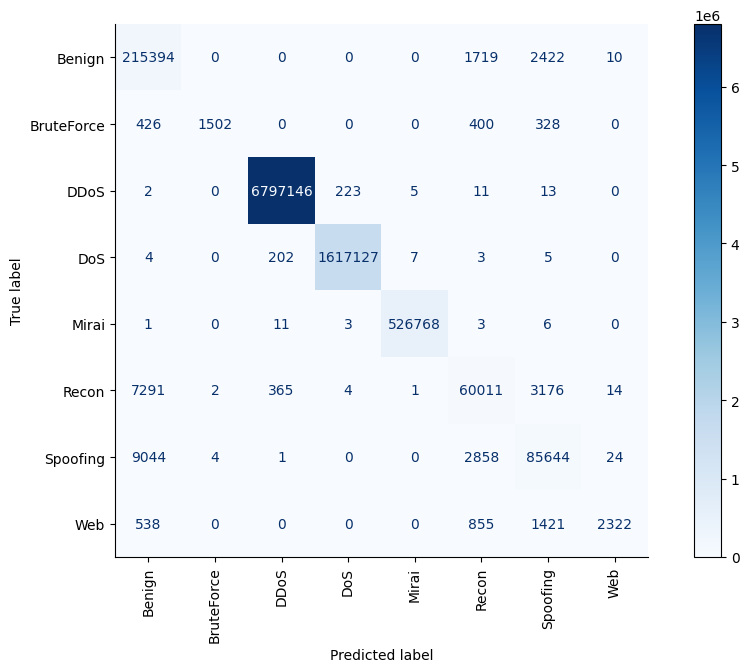

In [34]:
%%time
simplified_baseline_model = model_utils.model_load('simplified_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in simplified_baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = simplified_baseline_df_split
model_utils.evaluate_model(simplified_baseline_model, X_test, y_test)

# Optimized Baseline

## 33+1 Attacks

In [10]:
%%time

opt_baseline_model = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced',
    bootstrap=False,
    max_depth=45,
    max_features=17,
    n_estimators=80,
    n_jobs=n_jobs,
    random_state=seed
)

model_utils.train_model(
    opt_baseline_model,
    df_train[refined_features_list],
    df_train['label'],
    save_name='opt_baseline_random_forest'
)

NameError: name 'opt_baseline_df_split' is not defined

In [11]:
%%time
opt_baseline_model = model_utils.model_load('opt_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in opt_baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = opt_baseline_df_split
model_utils.evaluate_model(opt_baseline_model, X_test, y_test)

Loading model 'opt_baseline_random_forest' (7.87 GB)



KeyboardInterrupt



## 7+1 Attacks

In [ ]:
%%time

simplified_opt_baseline_model = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced',
    bootstrap=False,
    max_depth=45,
    max_features=17,
    n_estimators=80,
    n_jobs=n_jobs,
    random_state=seed
)

model_utils.train_model(
    simplified_opt_baseline_model,
    df_train[refined_features_list],
    df_train['general_label'],
    save_name='simplified_opt_baseline_random_forest'
)

In [ ]:
%%time
simplified_opt_baseline_model = model_utils.model_load('simplified_opt_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in simplified_opt_baseline_model.estimators_)}")

model_utils.evaluate_model(simplified_opt_baseline_model, df_test[refined_features_list], df_test['general_label'])

# Multi-Stage Model

In [10]:
simplified_first_layer_labels = {'DDoS', 'DoS', 'Mirai'}
simplified_second_layer_labels = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

first_layer_labels = {
    attack_type
    for layer_attack in simplified_first_layer_labels
    for attack_type in attack_category[layer_attack]
}

second_layer_labels = {
    attack_type
    for layer_attack in simplified_second_layer_labels
    for attack_type in attack_category[layer_attack]
}

## 33+1 attacks

In [11]:
%%time

multi_stage_model = MultiStageClassifier(
    default_label='BenignTraffic',
    stages=[
        ModelStage(
            model=DecisionTreeClassifier(
                class_weight='balanced',
                criterion='entropy',
                min_samples_split=5,
                random_state=seed
            ),
            labels=first_layer_labels
        ),
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                bootstrap=False,
                max_depth=45,
                max_features=17,
                n_estimators=80,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=second_layer_labels
        ),
    ]
)

model_utils.train_model(
    multi_stage_model,
    df_train[refined_features_list],
    df_train['label'],
    save_name='multi_stage_model'
)

Execution time (Model fit): 0:21:00.831309
CPU times: user 2h 22min 25s, sys: 30.1 s, total: 2h 22min 55s
Wall time: 21min 21s


MultiStageClassifier(default_label='BenignTraffic',
                     stages=[ModelStage(model=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=5, random_state=6958), labels={'DDoS-RSTFINFlood', 'DDoS-TCP_Flood', 'Mirai-greip_flood', 'DoS-HTTP_Flood', 'Mirai-greeth_flood', 'DoS-TCP_Flood', 'DDoS-ICMP_Fragmentation', 'DDoS-SynonymousIP_Flood...
                       criterion='entropy', max_depth=45, max_features=17,
                       n_estimators=80, n_jobs=20, random_state=6958), labels={'Recon-PingSweep', 'Uploading_Attack', 'Backdoor_Malware', 'CommandInjection', 'Recon-PortScan', 'Recon-OSScan', 'MITM-ArpSpoofing', 'Recon-HostDiscovery', 'VulnerabilityScan', 'SqlInjection', 'BrowserHijacking', 'XSS', 'DictionaryBruteForce', 'DNS_Spoofing'})])

Loading model 'multi_stage_model' (4.08 GB)
# Nodes (1st stage): 4951
# Nodes (2nd stage): 23797696
Execution time (Predict): 0:00:12.873701
                         precision    recall  f1-score   support

       Backdoor_Malware     0.8460    0.5682    0.6798       667
          BenignTraffic     0.9175    0.9879    0.9514    219545
       BrowserHijacking     0.9497    0.6339    0.7603      1191
       CommandInjection     0.9514    0.6413    0.7661      1129
 DDoS-ACK_Fragmentation     0.9999    0.9999    0.9999     57361
        DDoS-HTTP_Flood     0.9983    0.9986    0.9984      5771
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000   1439718
DDoS-ICMP_Fragmentation     0.9998    0.9998    0.9998     90845
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    819425
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    808659
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    811376
         DDoS-SlowLoris     0.9973    0.9983    0.9978      4740
DDoS-Synonymo

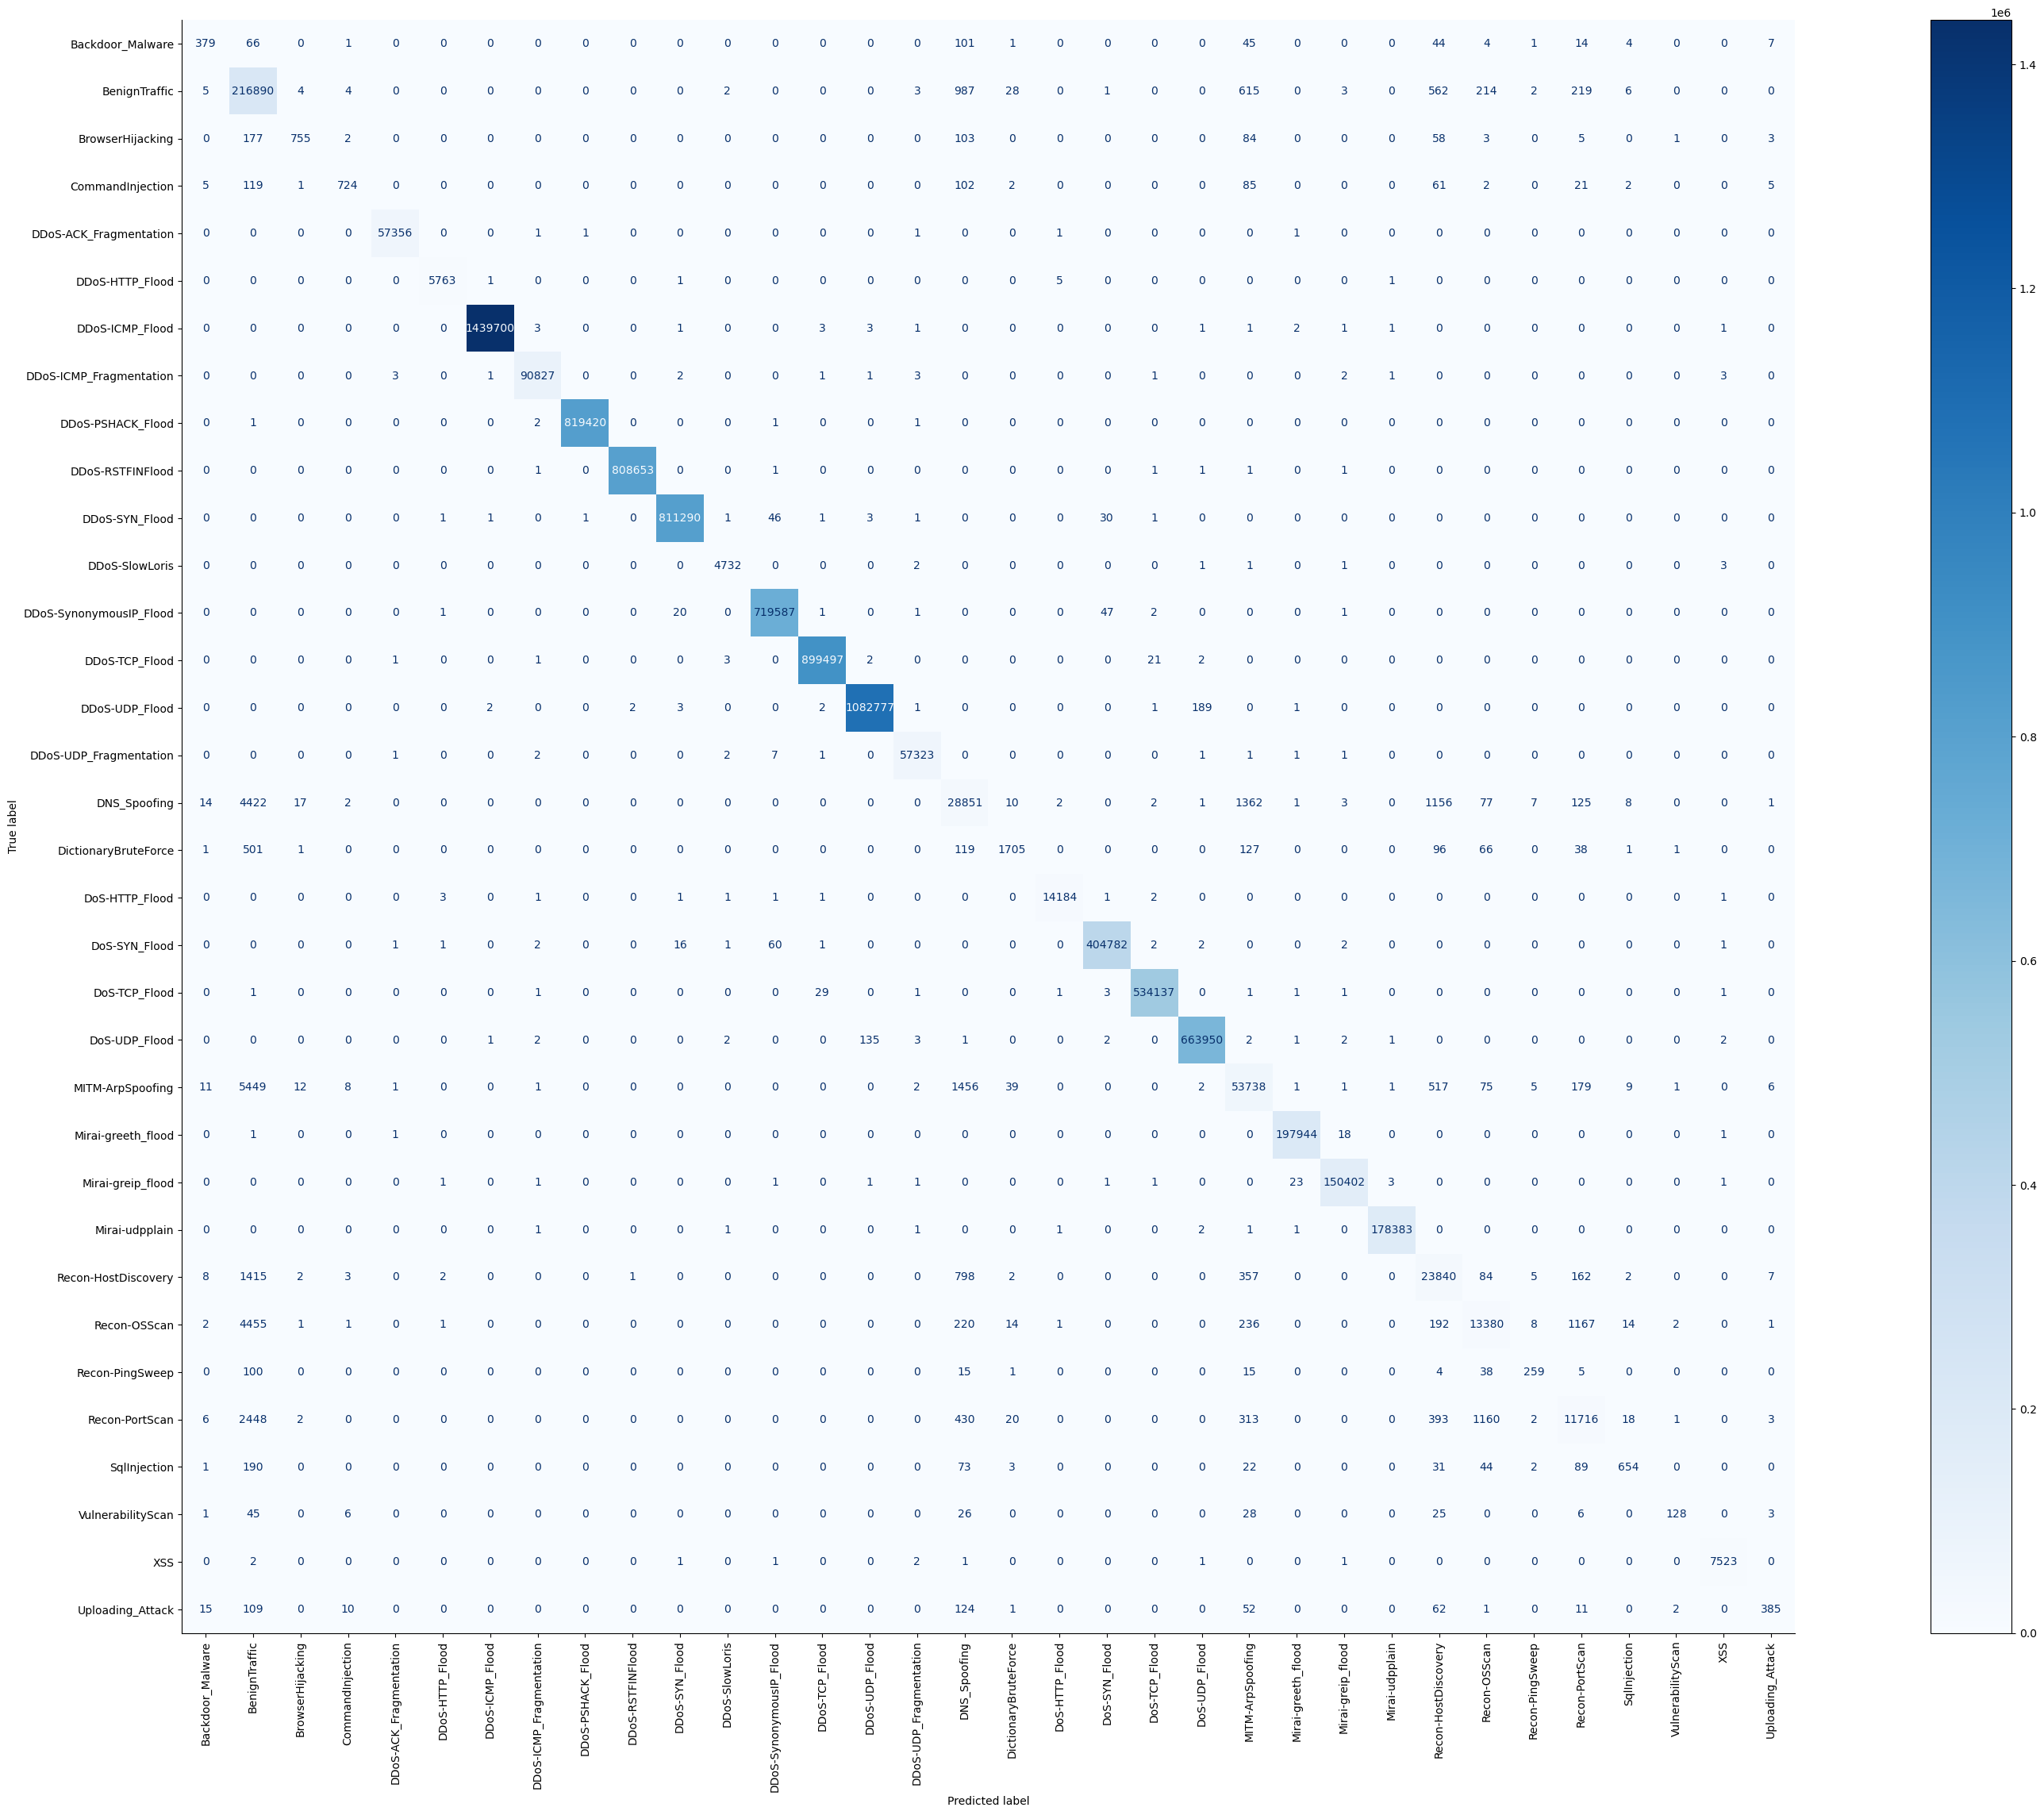

In [12]:
%%time
multi_stage_model = model_utils.model_load('multi_stage_model')

print(f"# Nodes (1st stage): {multi_stage_model.stages[0].model.tree_.node_count}")
print(f"# Nodes (2nd stage): {sum(tree.tree_.node_count for tree in multi_stage_model.stages[1].model.estimators_)}")

model_utils.evaluate_model(multi_stage_model, df_test[refined_features_list], df_test['label'])

## 7+1 Attacks

In [13]:
%%time

simplified_multi_stage_model = MultiStageClassifier(
    stages=[
        ModelStage(
            model=DecisionTreeClassifier(
                class_weight='balanced',
                criterion='entropy',
                min_samples_split=5,
                random_state=seed
            ),
            labels=simplified_first_layer_labels
        ),
        ModelStage(
            model=RandomForestClassifier(
            criterion='entropy',
            class_weight='balanced',
            bootstrap=False,
            max_depth=45,
            max_features=17,
            n_estimators=80,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=simplified_second_layer_labels
        ),
    ]
)

model_utils.train_model(
    simplified_multi_stage_model,
    df_train[refined_features_list],
    df_train['general_label'],
    save_name='simplified_multi_stage_model'
)

Execution time (Model fit): 0:17:25.601315
CPU times: user 1h 47min 46s, sys: 18 s, total: 1h 48min 4s
Wall time: 17min 35s


MultiStageClassifier(stages=[ModelStage(model=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=5, random_state=6958), labels={'DDoS', 'Mirai', 'DoS'}),
                             ModelStage(model=RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=45, max_features=17,
                       n_estimators=80, n_jobs=20, random_state=6958), labels={'Spoofing', 'BruteForce', 'Web', 'Recon'})])

Loading model 'simplified_multi_stage_model' (1.74 GB)
# Nodes (1st stage): 3465
# Nodes (2nd stage): 17923974
Execution time (Predict): 0:00:08.308736
              precision    recall  f1-score   support

      Benign     0.9355    0.9805    0.9575    219545
  BruteForce     0.9490    0.6382    0.7632      2656
        DDoS     1.0000    1.0000    1.0000   6797400
         DoS     0.9998    0.9998    0.9998   1617348
       Mirai     0.9999    1.0000    1.0000    526792
       Recon     0.9171    0.8722    0.8940     70864
    Spoofing     0.9328    0.8906    0.9112     97575
         Web     0.9402    0.6086    0.7389      5136

    accuracy                         0.9970   9337316
   macro avg     0.9593    0.8737    0.9081   9337316
weighted avg     0.9970    0.9970    0.9970   9337316

CPU times: user 1min 23s, sys: 6.27 s, total: 1min 29s
Wall time: 1min 15s


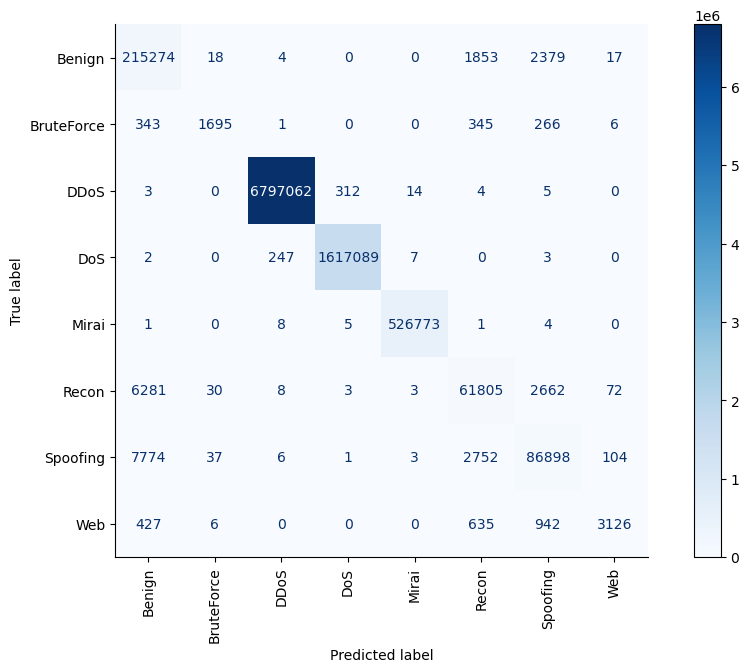

In [14]:
%%time
multi_stage_baseline_model = model_utils.model_load('simplified_multi_stage_model')

print(f"# Nodes (1st stage): {multi_stage_baseline_model.stages[0].model.tree_.node_count}")
print(f"# Nodes (2nd stage): {sum(tree.tree_.node_count for tree in multi_stage_baseline_model.stages[1].model.estimators_)}")

model_utils.evaluate_model(multi_stage_baseline_model, df_test[refined_features_list], df_test['general_label'])